# Tutorial: Conditional Normalizing Flows for MNIST
In this tutorial, we build and train a **Conditional Normalizing Flow (CNF)** to model the MNIST dataset using the [FrEIA](https://github.com/VLL-HD/FrEIA) library. Normalizing flows are invertible neural networks capable of modeling complex data distributions by transforming them into a simple base distribution (usually a standard Gaussian).

The model is *conditional* because it is trained to generate digits conditioned on their class label. We use CNFs not only for sample generation but also for evaluating the likelihood of an image belonging to a particular class.


## 1. Imports and Setup
We start by importing all necessary libraries for data handling, model definition, and visualization.

In [1]:
import torch  # PyTorch for building and training neural networks
from torchvision import datasets, transforms  # For downloading and transforming MNIST data
from torch.utils.data import DataLoader  # For efficient data loading
import matplotlib.pyplot as plt  # For plotting images and graphs
import torch.nn as nn  # For neural network components

import numpy as np  # For numerical operations

import FrEIA.framework as Ff  # Framework for normalizing flow graph construction
import FrEIA.modules as Fm  # Common modules like coupling layers and permutations

from fastprogress.fastprogress import master_bar, progress_bar  # For progress bars during training

## 2. Hyperparameters and Device Configuration
Define training parameters and determine whether to use GPU.

In [2]:
batch_size = 64  # Number of samples per batch during training
hidden_dimension = 1024  # Hidden layer size for subnetworks in coupling blocks
num_layers = 20  # Number of normalizing flow blocks
lr = 1e-3  # Learning rate
n_epochs = 100  # Total number of training epochs

device = "cuda:1" if torch.cuda.is_available() else "cpu"  # Use GPU if available


## 3. Gaussian Noise Transformation
Adds random Gaussian noise to the MNIST images for robustness.

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):  # Mean and standard deviation for noise
        self.mean = mean
        self.std = std

    def __call__(self, tensor):  # Adds Gaussian noise to an image tensor
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):  # For readable printing
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

## 4. Dataset and DataLoader
Load MNIST dataset with transformations for training and validation.

In [4]:
transform_train = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
    AddGaussianNoise(0.0, 0.01)  # Add Gaussian noise to training images
])

transform_val = transforms.Compose([
    transforms.ToTensor()  # Only convert to tensor for validation
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)  # Load training set
mnist_val = datasets.MNIST(root='./data', train=False, download=True, transform=transform_val)  # Load validation set

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)  # Load batches for training
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)  # Load batches for validation

## 5. Visualize Sample Images
Display a few MNIST digits to verify data loading and transformations.

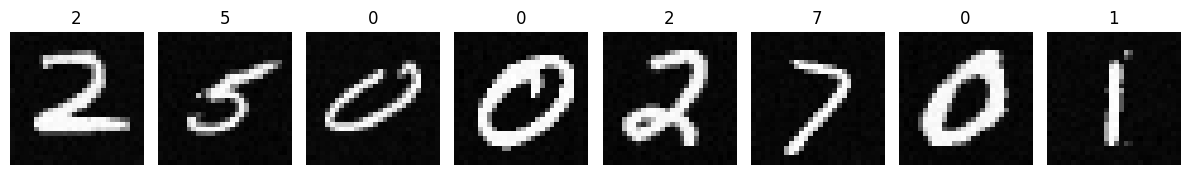

In [5]:
images, labels = next(iter(train_loader))  # Get a batch of images and labels from validation set
fig, axes = plt.subplots(1, 8, figsize=(12, 2))  # Set up plot grid
for i in range(8):  # Plot first 8 images
    axes[i].imshow(images[i].squeeze(), cmap='gray')  # Show grayscale image
    axes[i].set_title(f"{labels[i].item()}")  # Show label
    axes[i].axis('off')  # Hide axes
plt.tight_layout()  # Remove overlapping
plt.show()  # Display images

## 6. Utilities: One-Hot Encoding and Loss Plotting
Includes helper functions for label encoding and plotting training loss.

In [6]:
def one_hot(labels, num_classes=10):
    # Converts class labels to one-hot encoded vectors
    return torch.nn.functional.one_hot(labels, num_classes).float().to(labels.device)

In [7]:
def plot_loss_update(iteration, max_iterations, mb, batch_loss):
    # Updates loss graph during training
    x = range(1, iteration + 1)
    y = np.array(batch_loss)
    graphs = [[x, batch_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1 - x_margin, max_iterations + x_margin]
    y_bounds = [np.min(y) - y_margin, np.max(y)]
    mb.update_graph(graphs, x_bounds, y_bounds)  # Update graph in progress bar

## 7. Define Conditional Normalizing Flow (CNF) Model
This model is built using the FrEIA library. It consists of a series of GLOW coupling blocks conditioned on digit labels.

In [8]:
def subnet(in_dimensions, out_dimensions):
    # Defines a small neural network used inside the coupling blocks
    return nn.Sequential(
        nn.Linear(in_dimensions, hidden_dimension),  # First linear layer
        nn.LeakyReLU(),  # Non-linearity
        nn.Linear(hidden_dimension, out_dimensions)  # Output layer
    )

In [9]:
class CNF(nn.Module):
    def __init__(self, num_layers):
        super().__init__()

        cond = Ff.ConditionNode(10)  # Condition node for digit labels (10 classes)
        nodes = [cond, Ff.InputNode(1, 28, 28)]  # Start with input node and condition node
        nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}))  # Flatten image to 1D vector

        for _ in range(num_layers):
            # Add GLOW coupling block with conditioning
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock, {'subnet_constructor': subnet, 'clamp':1.0}, conditions=cond))
            # Add random permutation between blocks
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {}))

        nodes.append(Ff.OutputNode(nodes[-1]))  # Final output node

        self.network = Ff.ReversibleGraphNet(nodes)  # Construct reversible graph net

        # Gather parameters that require gradients
        self.trainable_parameters = [p for p in self.network.parameters() if p.requires_grad]
        for p in self.trainable_parameters:
            p.data = 0.01 * torch.randn_like(p)  # Initialize weights

    def forward(self, x, l):
        # Forward pass with label conditioning
        return self.network(x, c=one_hot(l), jac=True)

    def reverse_sample(self, l):
        # Generate samples conditioned on labels
        c = one_hot(l)
        bs = c.shape[0]  # Batch size
        z = torch.randn(bs, 28 * 28).to(device=c.device)  # Sample from normal distribution
        return self.network(z, c=c, rev=True)  # Reverse the flow

## 8. Loss Function
A key property of normalizing flows is that they transform an input $\mathbf{x}$ into a latent variable $\mathbf{z}$ via an invertible function $f$, such that:

$$
\mathbf{z} = f(\mathbf{x})
$$

The log-probability of an input $\mathbf{x}$ under the model is given by the **change of variables formula**:

$$
\log p(\mathbf{x}) = \log p(\mathbf{z}) + \log \left| \det \left(\frac{\partial f}{\partial \mathbf{x}} \right) \right| = \log p(\mathbf{z}) + \log |J|
$$

Here, $p(\mathbf{z})$ is typically a standard Gaussian distribution, and $|J|$ is the absolute value of the Jacobian determinant of the transformation.

Assuming $\mathbf{z} \sim \mathcal{N}(0, I)$, we can write:

$$
\log p(\mathbf{z}) = -\frac{1}{2}\|\mathbf{z}\|^2 + \text{const}
$$

Ignoring constants, our **negative log-likelihood loss** becomes:

$$
\mathcal{L}(\mathbf{x}) = \frac{1}{2}\|\mathbf{z}\|^2 - \log |J|
$$

In code, we normalize the log-determinant by the input dimensionality.

In [10]:
def loss_fn(z, log_j):
    # Loss = Gaussian log likelihood - log determinant of Jacobian
    return torch.mean(z**2) / 2 - torch.mean(log_j) / (28 * 28)

## 9. Initialize Model and Optimizer
Instantiate model, optimizer, and learning rate scheduler.

In [11]:
model = CNF(num_layers=num_layers).to(device);  # Move model to device
optimizer = torch.optim.Adam(model.trainable_parameters, lr=1e-4, weight_decay=1e-5)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=0.3)  # Learning rate scheduler

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): Flatten()
    (1): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=402, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=784, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=402, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=784, bias=True)
      )
    )
    (2): PermuteRandom()
    (3): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=402, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=784, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=402, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=784, bias

In [12]:
model.load_state_dict(torch.load('model.pt'));

## 11. Training Loop
Standard training loop with progress bars and loss visualization.

In [13]:
batch_loss_history = []  # Track loss per batch
mb = master_bar(range(n_epochs))  # Master progress bar

for epoch in mb:
    total_loss = 0
    pb = progress_bar(train_loader, parent=mb)  # Inner progress bar

    for i, (x, l) in enumerate(pb):
        x, l = x.to(device), l.to(device)  # Move data to GPU
        z, log_j = model(x, l)  # Forward pass

        nll = loss_fn(z, log_j)  # Compute loss
        nll.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.trainable_parameters, 10.)  # Clip gradients
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients

        total_loss += nll.item()
        batch_loss_history.append(nll.item())  # Save loss

        pb.comment = f"Loss: {nll.item():.4f}"  # Update comment

        if i % 100 == 0:
            # Update plot every 100 batches
            plot_loss_update(epoch*len(train_loader) + (i + 1), len(train_loader) * n_epochs, mb, batch_loss_history)

    scheduler.step()  # Adjust learning rate

KeyboardInterrupt: 

## 12. Save the Trained Model
Save model weights for later reuse.

In [18]:
torch.save(model.state_dict(), 'model.pt')

## 13. Sample Generation
Generate digit images by sampling from the model conditioned on class labels.

In [14]:
# Generate samples from the trained model and plot
def generate_samples(model, n_per_class=5):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(10, n_per_class, figsize=(n_per_class * 2, 10))  # Grid of images
    for digit in range(10):
        labels = torch.full((n_per_class,), digit, dtype=torch.long, device=device)  # Create labels
        samples = model.reverse_sample(labels)[0]  # Generate images
        samples = samples.view(-1, 1, 28, 28).detach().cpu()  # Reshape and move to CPU

        for i in range(n_per_class):
            axes[digit][i].imshow(samples[i].squeeze(), cmap='gray')  # Display image
            axes[digit][i].axis('off')  # Hide axis
            if i == 0:
                axes[digit][i].set_ylabel(str(digit), rotation=0, labelpad=20, fontsize=14)  # Label
    plt.tight_layout()
    plt.show()

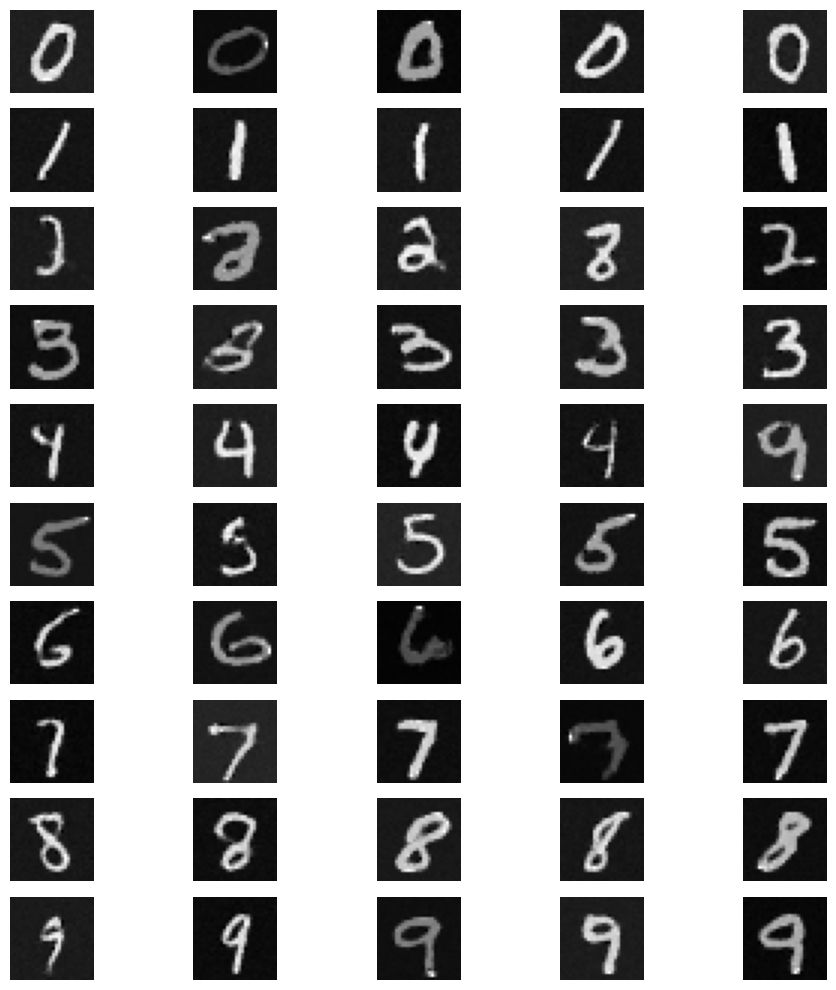

In [15]:
generate_samples(model, n_per_class=5)  # Generate and display images

## Log-Likelihood Evaluation

Once trained, a normalizing flow allows us to evaluate the **likelihood** of data under the learned distribution. In a conditional model, we expect the likelihood of an image to be **higher when conditioned on the correct label**.

To test this hypothesis, we compute two types of log-likelihoods:

1. **Matched Likelihood**: The log-likelihood of an image under the correct label (e.g., `p(x | label=x_label)`)
2. **Mismatched Likelihood**: The log-likelihood of the same image under an incorrect label (e.g., `p(x | label ≠ x_label)`)

## Why this matters
If the model has **truly learned the conditional distribution**, then we expect:

- $\log p(x | \text{correct label}) \gg \log p(x | \text{incorrect label})$

This gives us a **quantitative way to verify conditional modeling** — if the mismatch likelihoods are not significantly lower, then the conditioning mechanism may be underutilized.

We plot the histogram of matched and mismatched likelihoods to visually compare the distributions.


In [16]:
def compute_likelihoods(model, data_loader, num_batches=50):
    model.eval()  # Set to eval mode
    match_lls = []
    mismatch_lls = []

    for i, (x, l) in enumerate(data_loader):
        if i >= num_batches:
            break

        x, l = x.to(device), l.to(device)
        z, log_j = model(x, l)  # Log-likelihood with correct label
        match_ll = -loss_fn(z, log_j).item()
        match_lls.append(match_ll)

        l_mismatch = (l + torch.randint(1, 10, l.shape).to(device)) % 10  # Change labels
        z_mm, log_j_mm = model(x, l_mismatch)  # Log-likelihood with wrong label
        mismatch_ll = -loss_fn(z_mm, log_j_mm).item()
        mismatch_lls.append(mismatch_ll)

    return match_lls, mismatch_lls

def plot_likelihood_comparison(match_lls, mismatch_lls):
    plt.figure(figsize=(8, 5))
    plt.hist(match_lls, bins=30, alpha=0.6, label='Match', density=True)
    plt.hist(mismatch_lls, bins=30, alpha=0.6, label='Mismatch', density=True)
    plt.axvline(np.mean(match_lls), color='blue', linestyle='--', label=f'Match Mean: {np.mean(match_lls):.2f}')
    plt.axvline(np.mean(mismatch_lls), color='orange', linestyle='--', label=f'Mismatch Mean: {np.mean(mismatch_lls):.2f}')
    plt.xlabel("Log-likelihood (Negative Loss)")
    plt.ylabel("Density")
    plt.title("Likelihood Comparison: Matching vs Mismatching Labels")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

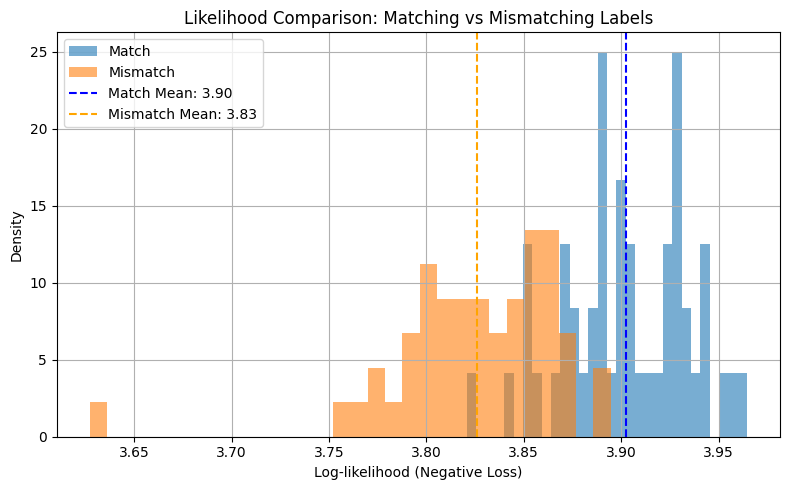

In [17]:
match_lls, mismatch_lls = compute_likelihoods(model, val_loader)  # Get likelihood scores
plot_likelihood_comparison(match_lls, mismatch_lls)  # Plot comparison